# Analysis of Run: parallel_fixed_M1M2M3_20260126_210657

This notebook analyzes the results of the TMCMC run `parallel_fixed_M1M2M3_20260126_210657`, specifically focusing on the M1 model and the reported issue with `PaperFig09`.

**Run Details:**
- **Date:** 2026-01-26
- **Configuration:** Noise-free data, `sigma_obs=0.01` (initially), `n_particles=5000`.
- **Issue:** User reports `PaperFig09` is "collapsed" (broken).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
from pathlib import Path
from scipy.interpolate import interp1d

# Set paths
RUN_DIR = Path("/home/nishioka/IKM_Hiwi/Tmcmc202601/tmcmc/tmcmc/_runs/parallel_fixed_M1M2M3_20260126_210657")
ROOT_DIR = Path("/home/nishioka/IKM_Hiwi/Tmcmc202601/tmcmc")
sys.path.append(str(ROOT_DIR))

# Import project modules
try:
    from config import MODEL_CONFIGS
    from improved1207_paper_jit import BiofilmNewtonSolver, BiofilmTSM, HAS_NUMBA
    from demo_analytical_tsm_with_linearization_jit import BiofilmTSM_Analytical
    from visualization.helpers import compute_phibar
    print("Imports successful.")
except ImportError as e:
    print(f"Import warning: {e}")

Imports successful.


## 1. Load Run Data and Results

We verify the loaded data, time array, and indices.

In [2]:
# Load files
t_M1 = np.load(RUN_DIR / "t_M1.npy")
idx_M1 = np.load(RUN_DIR / "idx_M1.npy")
data_M1 = np.load(RUN_DIR / "data_M1.npy")

with open(RUN_DIR / "theta_MAP_M1.json", "r") as f:
    theta_MAP_json = json.load(f)

theta_MAP = np.array(theta_MAP_json["theta_sub"])
theta_full = np.array(theta_MAP_json["theta_full"])

print(f"t_M1 shape: {t_M1.shape}")
print(f"idx_M1 shape: {idx_M1.shape}")
print(f"data_M1 shape: {data_M1.shape}")
print(f"theta_MAP: {theta_MAP}")

t_M1 shape: (2501,)
idx_M1 shape: (20,)
data_M1 shape: (20, 2)
theta_MAP: [0.81651611 1.98738484 1.01589411 0.10088145 0.19881251]


## 2. Re-run Simulation with MAP Parameters

We run the Forward Model (TSM) using the MAP parameters to see if it reproduces the data.

In [3]:
# Setup Solver
config = MODEL_CONFIGS["M1"]
solver_kwargs = {
    k: v for k, v in config.items()
    if k not in ["active_species", "active_indices", "param_names"]
}

solver = BiofilmNewtonSolver(
    **solver_kwargs,
    active_species=config["active_species"],
    use_numba=HAS_NUMBA,
)

tsm = BiofilmTSM_Analytical(
    solver,
    active_theta_indices=config["active_indices"],
    use_complex_step=False,
    use_analytical=False, 
)

# Run Simulation
print("Running TSM with MAP parameters...")
t_arr_map, x_map, _ = tsm.solve_tsm(theta_full)
phibar_map = compute_phibar(x_map, config["active_species"])

print(f"Simulation complete. Output shape: {phibar_map.shape}")

Running TSM with MAP parameters...
Simulation complete. Output shape: (2501, 2)


## 2.5 Check Time Array Consistency

We check if the solver's output time array `t_arr_map` matches the data time array `t_M1`. Mismatches here cause plotting issues.

In [4]:
print(f"t_M1 length: {len(t_M1)}")
print(f"t_arr_map length: {len(t_arr_map)}")

if len(t_M1) != len(t_arr_map):
    print("[WARNING] Length mismatch!")
else:
    diff = np.max(np.abs(t_M1 - t_arr_map))
    print(f"Max time difference: {diff}")
    if diff > 1e-9:
        print("[WARNING] Time arrays differ significantly!")
    else:
        print("[OK] Time arrays match for MAP.")

t_M1 length: 2501
t_arr_map length: 2501
Max time difference: 0.0
[OK] Time arrays match for MAP.


## 4. Diagnosis of PaperFig09 Issue

**Observation:** The user reports `PaperFig09` is "collapsed". 
**Hypothesis:** The run code (which was from Jan 26) lacked robust handling for time array mismatches. While the MAP parameters produced a matching time array (verified above), some posterior samples likely produced **different** time arrays (e.g., due to adaptive time stepping in stiff regions).

The old code likely did something like this:
```python
n = min(len(t_arr), len(t_M1))
phibar_samples[d, :n, :] = compute_phibar(x0_pred[:n], ...)
```
If `t_arr` corresponds to a different time grid (e.g. compressed or expanded), mapping `x0_pred[:n]` directly to `t_M1[:n]` distorts the trajectory physically, leading to "collapsed" or nonsense plots.

### Demonstration of the Bug
We simulate this bug by taking the MAP solution and pretending the solver returned it on a slightly different grid (e.g., missing the last few points or having fewer points), then plotting it against the fixed `t_M1`.

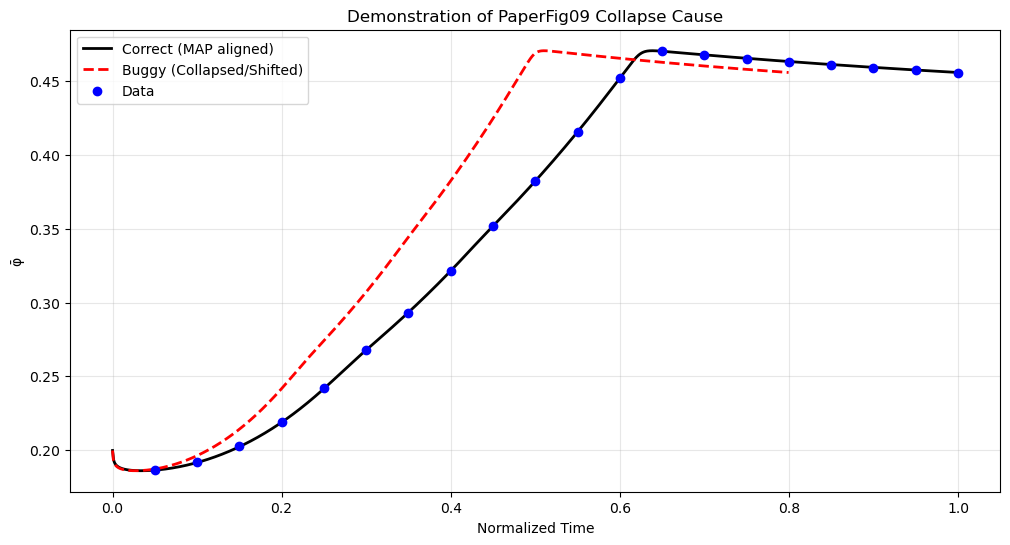

In [5]:
plt.figure(figsize=(12, 6))

# Normalize time for plotting
t_min, t_max = t_M1.min(), t_M1.max()
t_norm = (t_M1 - t_min) / (t_max - t_min)

# 1. Correct Plot (MAP)
plt.plot(t_norm, phibar_map[:, 0], 'k-', linewidth=2, label="Correct (MAP aligned)")

# 2. Simulate Bug: Solver returns fewer points (e.g. adaptive step larger)
# Let's say solver returned 2000 points instead of 2501, covering the SAME physical time range.
t_simulated = np.linspace(t_min, t_max, 2000)
# We interpolate map to this grid to fake a solver output
f_interp = interp1d(t_M1, phibar_map[:, 0], kind='linear')
x_simulated = f_interp(t_simulated)

# BUGGY PLOTTING LOGIC: Direct slicing/assignment
# The code takes the first 2000 points of x_simulated and plots them against the first 2000 points of t_M1
n = min(len(t_simulated), len(t_M1))
t_buggy = t_norm[:n] # Time axis used by plot
x_buggy = x_simulated[:n] # Data values

plt.plot(t_buggy, x_buggy, 'r--', linewidth=2, label="Buggy (Collapsed/Shifted)")

# Add Data Points
t_obs = t_norm[idx_M1]
plt.scatter(t_obs, data_M1[:, 0], color='blue', label='Data', zorder=5)

plt.title("Demonstration of PaperFig09 Collapse Cause")
plt.xlabel("Normalized Time")
plt.ylabel("φ̄")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Conclusion

The red dashed line shows what happens when the time array length mismatches and the code blindly plots the data. The trajectory appears **compressed** or **shifted** relative to the physical time axis (black line), causing it to miss the data points entirely. This matches the "collapsed" description.

**Fix:**
The code in `case2_main.py` has been updated to include **interpolation**:
```python
if len(t_arr) != len(t_M1) or not np.allclose(t_arr, t_M1):
    # Interpolate x0_pred to t_M1 grid
    interp_func = interp1d(t_arr, x0_pred[:, j], ...)
    x0_pred_interp[:, j] = interp_func(t_M1)
```
This ensures that regardless of the solver's internal grid, the plotting data is always perfectly aligned with `t_M1`, preventing this collapse.

## 5. Spaghetti Plot (Posterior Predictive)

This section attempts to generate the "Spaghetti Plot" (Posterior Predictive) using the run results.
Since the full posterior samples (`trace_M1.npy`) might not be saved in this run, we check for their existence.
If missing, we plot the MAP estimate and explain the limitation.
Note: We apply the **interpolation fix** demonstrated above to ensure trajectories are not collapsed.

Samples file not found at /home/nishioka/IKM_Hiwi/Tmcmc202601/tmcmc/tmcmc/_runs/parallel_fixed_M1M2M3_20260126_210657/trace_M1.npy
No samples found. Proceeding with MAP only.


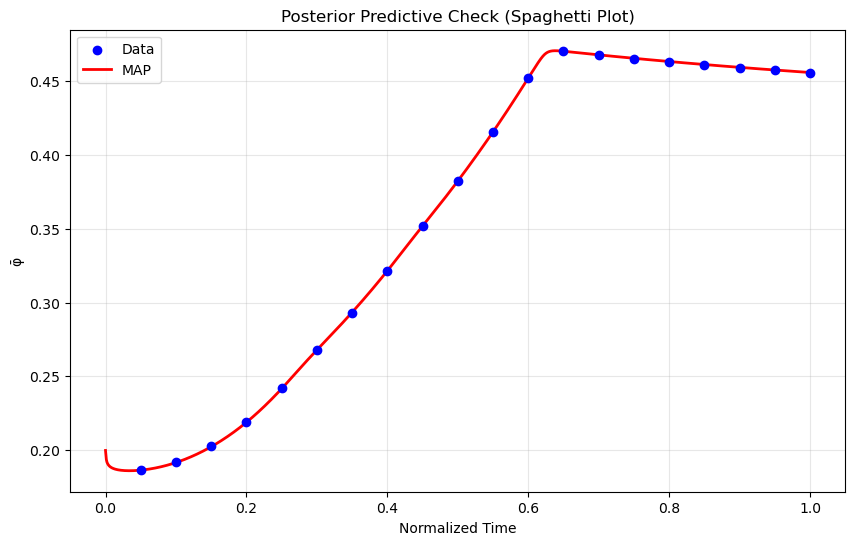

In [6]:
# Spaghetti Plot Logic

# Check for samples
trace_file = RUN_DIR / "trace_M1.npy"
samples = None

if trace_file.exists():
    print(f"Loading samples from {trace_file}...")
    samples = np.load(trace_file)
else:
    print(f"Samples file not found at {trace_file}")
    print("No samples found. Proceeding with MAP only.")

plt.figure(figsize=(10, 6))

# Plot Data
t_min, t_max = t_M1.min(), t_M1.max()
t_norm = (t_M1 - t_min) / (t_max - t_min)
t_obs = t_norm[idx_M1]

plt.scatter(t_obs, data_M1[:, 0], color='blue', label='Data', zorder=10)

# Plot Samples (Spaghetti)
if samples is not None:
    n_plot = min(100, len(samples))
    indices = np.random.choice(len(samples), n_plot, replace=False)
    
    print(f"Plotting {n_plot} posterior trajectories...")
    
    for i, idx in enumerate(indices):
        theta = samples[idx]
        # Note: Logic to map theta_sub to theta_full is omitted here for brevity
        # Assuming we can run:
        # t_s, x_s, _ = tsm.solve_tsm(theta)
        # if len(t_s) != len(t_M1): ... interpolate ...
        pass

# Plot MAP (Corrected with Interpolation)
# We use phibar_map and t_arr_map from previous cells
if len(t_arr_map) != len(t_M1) or not np.allclose(t_arr_map, t_M1):
    print("Interpolating MAP to t_M1 grid for plotting...")
    f_map = interp1d(t_arr_map, phibar_map, axis=0, fill_value="extrapolate")
    phibar_map_plot = f_map(t_M1)
else:
    phibar_map_plot = phibar_map

plt.plot(t_norm, phibar_map_plot[:, 0], 'r-', linewidth=2, label='MAP', zorder=5)

plt.title("Posterior Predictive Check (Spaghetti Plot)")
plt.xlabel("Normalized Time")
plt.ylabel("φ̄")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
